In [1]:
%pip install torchinfo

from tensorflow.python.client import device_lib
device_lib.list_local_devices()

Note: you may need to restart the kernel to use updated packages.


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 7253039058282503513
 xla_global_id: -1]

In [2]:
PM_train = './CMaps/train_FD001.txt'
PM_test = './CMaps/test_FD001.txt'
PM_truth = './CMaps/RUL_FD001.txt'

# Binary classification
Predict if an asset will fail within certain time frame (e.g. cycles)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Setting seed for reproducibility
np.random.seed(1234)
PYTHONHASHSEED = 0

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM
from torchinfo import summary
import keras

# define path to save model
model_path = 'binary_model.keras'

## Data Ingestion

In [4]:
# Read training data - Aircraft engine run-to-failure data
columns = ['unit_number', 'time_in_cycles', 'operational_setting_1', 'operational_setting_2', 'operational_setting_3'] + \
          [f'sensor_measurement_{i}' for i in range(1, 22)]

train_df = pd.read_csv(PM_train, sep='\s+', header=None, names=columns) # Read the txt file, use appropriate separator and header

train_df.drop(['sensor_measurement_1', 'sensor_measurement_5', 'sensor_measurement_10', 'sensor_measurement_16', 'sensor_measurement_18', 'sensor_measurement_19' ], axis=1, inplace=True)  # Explore the data on your own and remove unnecessary columns

train_df.columns = ['unit_number', 'time_in_cycles', 'operational_setting_1', 'operational_setting_2', 'operational_setting_3'] + \
                [f'sensor_measurement_{i}' for i in range(1, 16)]  # Assign names to all the columns

# train_df = train_df.sort_values([NotImplemented, NotImplemented])  # Sort by id and cycle

# Read test data - Aircraft engine operating data without failure events recorded
test_df = pd.read_csv(PM_test, sep='\s+', header=None, names=columns)  # Read the txt file, use appropriate separator and header
test_df.drop(['sensor_measurement_1', 'sensor_measurement_5', 'sensor_measurement_10', 'sensor_measurement_16', 'sensor_measurement_18', 'sensor_measurement_19' ], axis=1, inplace=True)  # Explore the data on your own and remove unnecessary columns
test_df.columns = ['unit_number', 'time_in_cycles', 'operational_setting_1', 'operational_setting_2', 'operational_setting_3'] + \
                [f'sensor_measurement_{i}' for i in range(1, 16)]  # Assign names to all the columns

# Read ground truth data - True remaining cycles for each engine in testing data

truth_df = pd.read_csv(PM_truth, sep='\s+', header=None, names=['remaining_life']) # Read the txt file, use appropriate separator and header
# truth_df.drop(NotImplemented, axis=1, inplace=True)  # Explore the data on your own and remove unnecessary columns


<>:5: SyntaxWarning: invalid escape sequence '\s'
<>:15: SyntaxWarning: invalid escape sequence '\s'
<>:22: SyntaxWarning: invalid escape sequence '\s'
<>:5: SyntaxWarning: invalid escape sequence '\s'
<>:15: SyntaxWarning: invalid escape sequence '\s'
<>:22: SyntaxWarning: invalid escape sequence '\s'
C:\Users\jardi\AppData\Local\Temp\ipykernel_16768\854265355.py:5: SyntaxWarning: invalid escape sequence '\s'
  train_df = pd.read_csv(PM_train, sep='\s+', header=None, names=columns) # Read the txt file, use appropriate separator and header
C:\Users\jardi\AppData\Local\Temp\ipykernel_16768\854265355.py:15: SyntaxWarning: invalid escape sequence '\s'
  test_df = pd.read_csv(PM_test, sep='\s+', header=None, names=columns)  # Read the txt file, use appropriate separator and header
C:\Users\jardi\AppData\Local\Temp\ipykernel_16768\854265355.py:22: SyntaxWarning: invalid escape sequence '\s'
  truth_df = pd.read_csv(PM_truth, sep='\s+', header=None, names=['remaining_life']) # Read the txt f

## Data Preprocessing

In [5]:
#######
# TRAIN
#######
# Data Labeling - generate column RUL (Remaining Useful Life or Time to Failure)

# TODO: Calculate the maximum cycle value for each engine (id) and store it in a new DataFrame (rul)
rul = train_df.groupby('unit_number')['time_in_cycles'].max().reset_index()
# TODO: Rename the columns in the rul DataFrame

rul.columns = ['unit_number', 'max_time_in_cycle']
# TODO: Merge the rul DataFrame with the original train_df based on the 'id' column
train_df = train_df.merge(rul, on='unit_number')

# TODO: Calculate the Remaining Useful Life (RUL) by subtracting the current cycle from the maximum cycle
train_df['RUL'] = train_df['max_time_in_cycle'] - train_df['time_in_cycles']


#TODO: Remove the temporary column used to calculate RUL
train_df.drop(columns=['max_time_in_cycle'], axis=1, inplace=True)

# Generate label columns for training data
# We will only make use of "label1" for binary classification,
# while trying to answer the question: is a specific engine going to fail within w1 cycles?
w1 = 30
w0 = 15

# TODO: Create a binary label ('label1') indicating if the engine will fail within w1 cycles (1) or not (0)
train_df['label1'] = train_df['RUL'].apply(lambda x: 1 if x <= w1 else 0) # Replace with the correct threshold value and label values
# TODO: Initialize a second label ('label2') as a copy of 'label1'
train_df['label2'] = train_df['label1'].copy()
# TODO: Update 'label2' to indicate if the engine will fail within w0 cycles (2) or not (0/1)
train_df.loc[train_df['RUL'] <= w0, 'label2'] = 2 # Replace with the correct threshold value and label value

# MinMax normalization (from 0 to 1)
# TODO: Create a normalized version of the 'cycle' column (e.g., 'cycle_norm') using the original 'cycle' values
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

train_df['cycle_norm'] = scaler.fit_transform(train_df[['time_in_cycles']])  # Replace with the correct normalization code
# TODO: Select the columns to be normalized (all columns except 'id', 'cycle', 'RUL', 'label1', and 'label2')
cols_normalize = train_df.drop(columns=['unit_number', 'time_in_cycles', 'RUL', 'label1', 'label2']).columns # Replace with the correct column selection code

# TODO: Initialize a MinMaxScaler object to scale values between 0 and 1
# min_max_scaler = NotImplemented  # Replace with the correct scaler initialization code

# TODO: Apply MinMaxScaler to the selected columns and create a new normalized DataFrame
norm_train_df = train_df.copy()   # Replace with the correct normalization code
norm_train_df[cols_normalize] = scaler.fit_transform(train_df[cols_normalize])

# TODO: Join the normalized DataFrame with the original DataFrame (excluding normalized columns)
original_df = train_df.drop(columns=cols_normalize)

join_df = pd.concat([original_df, norm_train_df[cols_normalize]], axis=1)  # Replace with the correct join code

# TODO: Reorder the columns in the joined DataFrame to match the original order
train_df = join_df.reindex(columns=train_df.columns)  # Replace with the correct reindexing code

######
# TEST
######
# MinMax normalization (from 0 to 1)
# TODO: Similar to the MinMax normalization done for Train, complete the code below.
test_df['cycle_norm'] = scaler.fit_transform(test_df[['time_in_cycles']])
norm_test_df = test_df.copy()
norm_test_df[cols_normalize] = scaler.fit_transform(test_df[cols_normalize])

test_join_df = pd.concat([test_df.drop(columns=cols_normalize), norm_test_df[cols_normalize]], axis=1)
test_df = test_join_df.reindex(columns=test_df.columns)

# We use the ground truth dataset to generate labels for the test data.
# generate column max for test data
# TODO: Calculate the maximum cycle value for each engine (id) in the test data and store it in a new DataFrame (rul)
rul = test_df.groupby('unit_number')['time_in_cycles'].max().reset_index()

# TODO: Rename the columns in the rul DataFrame
rul.columns = ['unit_number', 'max_time_in_cycles']

# TODO: Merge the rul DataFrame with the original test_df based on the 'id' column
truth_df.columns = ['more']
truth_df['unit_number'] = truth_df.index + 1
truth_df['max'] = rul['max_time_in_cycles'] + truth_df['more']

# TODO: Remove the temporary column used to calculate RUL
truth_df.drop('more', axis=1, inplace=True)

# TODO: Merge the adjusted truth_df with the test_df to generate RUL values for test data
test_df = test_df.merge(truth_df[['unit_number', 'max']], on = 'unit_number', how = 'left')

# TODO: Calculate the Remaining Useful Life (RUL) by subtracting the current cycle from the maximum cycle
test_df['RUL'] = test_df['max'] - test_df['time_in_cycles']

# TODO: Remove the temporary column used to calculate RUL
test_df.drop('max', axis=1, inplace=True)

# Generate binary label columns (label1 and label2) based on RUL values and thresholds w0 and w1
# TODO: Similar to what you did in the train dataframe
test_df['label1'] = test_df['RUL'].apply(lambda x: 1 if x <= w1 else 0)

test_df['label2'] = test_df['label1'].copy()
test_df.loc[test_df['RUL'] <= w0, 'label2'] = 2

In [6]:
print(test_df.head())
print(train_df.head())

   unit_number  time_in_cycles  operational_setting_1  operational_setting_2  \
0            1               1                0.65625               0.692308   
1            1               2                0.34375               0.230769   
2            1               3                0.53125               0.538462   
3            1               4                0.77500               0.461538   
4            1               5                0.60000               0.461538   

   operational_setting_3  sensor_measurement_1  sensor_measurement_2  \
0                    0.0              0.596215              0.421968   
1                    0.0              0.182965              0.504025   
2                    0.0              0.419558              0.464814   
3                    0.0              0.413249              0.391587   
4                    0.0              0.435331              0.471306   

   sensor_measurement_3  sensor_measurement_4  sensor_measurement_5  ...  \
0         

## LSTM

In [7]:
# TODO: Define window size and sequence length
sequence_length = 50  # Replace with the desired sequence length

# Function to reshape features into (samples, time steps, features)
def generate_sequences(id_df, sequence_length, feature_columns):
    """Generate sequences from a dataframe for a given id.
    Sequences that are under the sequence length will be considered.
    """
    data_matrix = id_df[feature_columns].values
    num_elements = data_matrix.shape[0]

    for start in range(0, num_elements - sequence_length + 1):
        end = start + sequence_length
        yield data_matrix[start:end]  # TODO: Replace with the correct code to yield sequences of feature values

# TODO: Select feature columns for sequence generation (e.g., sensor readings, settings)
sensor_columns = [f'sensor_measurement_{i}' for i in range(1, 16)]  # TODO: Replace with the correct list of sensor column names
settings_columns = ['operational_setting_1', 'operational_setting_2', 'operational_setting_3']  # TODO: Replace with the correct list of sequence column names (including settings and sensors)
sequence_columns = sensor_columns + settings_columns
print(len(sequence_columns))

# TODO: Generate sequences for all engine ids in the training data
all_sequences = []
unit_numbers = train_df['unit_number'].unique()

for engine_id in unit_numbers:
    id_df = train_df[train_df['unit_number'] == engine_id]
    sequence_generator = list(generate_sequences(id_df, sequence_length, sequence_columns))  # TODO: Replace with the correct code to generate sequences
    all_sequences.extend(sequence_generator)

# TODO: Convert generated sequences to a numpy array for LSTM input
#sequence_array = NotImplemented  # TODO: Replace with the correct code to convert sequences to numpy array
X_sequences = np.array(all_sequences)


# TODO: Function to generate labels
def generate_labels(id_df, sequence_length, label_column):
    """Generate labels for a given id."""
    data_matrix = id_df[label_column].values
    num_elements = data_matrix.shape[0]
    labels = []

    for start in range(0, num_elements - sequence_length + 1):
        end = start + sequence_length
        label = data_matrix[end - 1]  # Label for the end of the sequence # Label for the end of the sequence
        labels.append(label)
    return np.array(labels)  # TODO: Replace with the correct code to generate labels

# TODO: Generate labels for all engine ids in the training data
#label_generator = NotImplemented  # TODO: Replace with the correct code to generate labels for all engine ids
#label_array = NotImplemented  # TODO: Replace with the correct code to convert labels to a numpy array
# Generate labels for all engine ids in the training data
all_labels1 = []
all_labels2 = []
unit_numbers = train_df['unit_number'].unique()

for engine_id in unit_numbers:
    id_df = train_df[train_df['unit_number'] == engine_id]
    label1_array = generate_labels(id_df, sequence_length, 'label1')  
    all_labels1.extend(label1_array)

for engine_id in unit_numbers:
    id_df = train_df[train_df['unit_number'] == engine_id]
    label2_array = generate_labels(id_df, sequence_length, 'label2') 
    all_labels2.extend(label2_array)


# Convert labels to a numpy array
label1_array = np.array(all_labels1)
label2_array = np.array(all_labels2)

# Check the shape
print(f"label1_array shape: {label1_array.shape}")
print(label1_array)

print(f"label2_array shape: {label2_array.shape}")
print(label2_array)

print(f"x_sequences shape: {X_sequences.shape}")

18
label1_array shape: (15731,)
[0 0 0 ... 1 1 1]
label2_array shape: (15731,)
[0 0 0 ... 2 2 2]
x_sequences shape: (15731, 50, 18)


In [8]:
# Define the number of features and output units
nb_features = X_sequences.shape[2]

if label1_array.ndim == 1:
    label1_array = label1_array.reshape(-1, 1)
nb_out = label1_array.shape[1]

# Create a Sequential model
model = Sequential()

# TODO: Add LSTM layers and Dropout layers to the model
# Note: Limit the total number of model parameters to 10,000
# Your code here:
model.add(LSTM(units=16, input_shape=(sequence_length, nb_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=8, return_sequences=False))
model.add(Dropout(0.2))

# Add a Dense output layer with sigmoid activation
model.add(Dense(units=nb_out, activation='sigmoid'))

# Compile the model with binary crossentropy loss and Adam optimizer
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# TODO: Print the model summary
model.summary()

c:\Users\jardi\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50, 16)         │         2,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 8)              │           800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,049 (11.91 KB)

 Trainable params: 3,049 (11.91 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# TODO: Fit the network to the training data
history = model.fit(
    X_sequences,
    label1_array,
    epochs=30,  # TODO: Replace with the desired number of training epochs
    batch_size=32,  # TODO: Replace with the desired batch size
    validation_split=0.2,  # TODO: Replace with the desired validation split proportion
    verbose=1,  # TODO: Replace with the desired verbosity level
    callbacks = [
        # TODO: Early stopping callback to stop training when validation loss stops improving
        keras.callbacks.EarlyStopping(
            monitor='val_loss',
            min_delta=0.001,  # TODO: Replace with the minimum change in validation loss to qualify as improvement
            patience=5,  # TODO: Replace with the number of epochs to wait before stopping training
            verbose=1,  # TODO: Replace with the desired verbosity level
            mode='min'
        ),
        # TODO: Model checkpoint callback to save the best model based on validation loss
        keras.callbacks.ModelCheckpoint(
            'best_model.keras',  # TODO: Replace with the file path to save the best model
            monitor='val_loss',
            save_best_only=True,
            mode='min',
            verbose=1  # TODO: Replace with the desired verbosity level
        )
    ]
)

Epoch 1/30
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8570 - loss: 0.3578
Epoch 1: val_loss improved from inf to 0.12592, saving model to best_model.keras
394/394 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - accuracy: 0.8572 - loss: 0.3575 - val_accuracy: 0.9523 - val_loss: 0.1259
Epoch 2/30
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9549 - loss: 0.1259
Epoch 2: val_loss improved from 0.12592 to 0.11898, saving model to best_model.keras
394/394 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.9549 - loss: 0.1259 - val_accuracy: 0.9555 - val_loss: 0.1190
Epoch 3/30
393/394 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9591 - loss: 0.1055
Epoch 3: val_loss improved from 0.11898 to 0.07476, saving model to best_model.keras
394/394 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - accuracy: 0.9591 - loss: 0.1055 - val_accuracy: 0.9679 - val_loss: 0.0748
Epoch 4/30
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9626 - loss: 0.0900
Epoch 4: val_loss did not improve from 0.074

## Model Eval on Test Set

Training Accuracy: 0.9722663760185242
Validation Accuracy: 0.9539243578910828


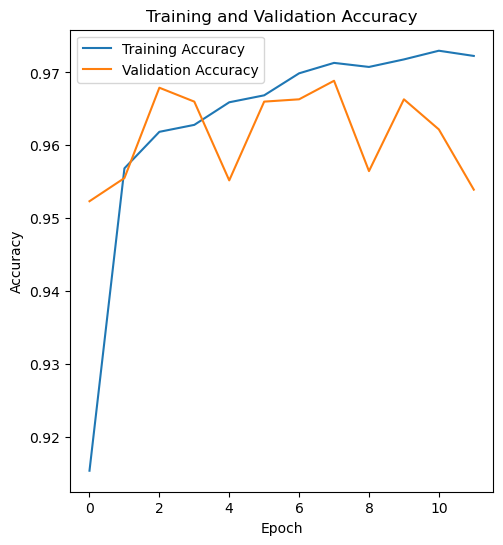

Training Loss: 0.06595466285943985
Validation Loss: 0.10512415319681168


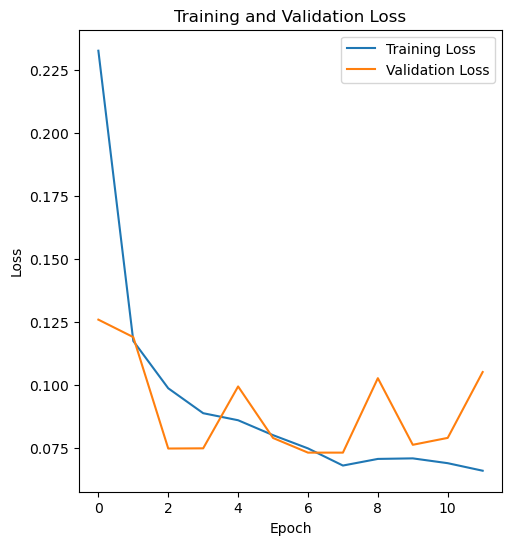

Training Loss: 0.07445885986089706
Training Accuracy: 0.967707097530365
492/492 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step
y_true_flat shape: (15731,), unique values: {0, 1}
y_pred_flat shape: (15731,), unique values: {0, 1}
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[12580    51]
 [  431  2669]]
precision =  0.98125 
 recall =  0.8609677419354839


In [10]:
# TODO: summarize history for Accuracy
print("Training Accuracy:", history.history['accuracy'][-1])
print("Validation Accuracy:", history.history['val_accuracy'][-1])

# TODO: Plot the training & validation accuracy over epochs and display the plot
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# TODO: Save the plot to a file
plt.savefig('accuracy_plot.png')

plt.show()


# TODO: summarize history for Loss
print("Training Loss:", history.history['loss'][-1])
print("Validation Loss:", history.history['val_loss'][-1])

# TODO: Plot the training & validation loss over epochs and display the plot
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# TODO: Save the plot to a file
plt.savefig('loss_plot.png')

plt.show()

# TODO: Use the evaluate method to calculate the accuracy of the model on the training data
scores = model.evaluate(X_sequences, label1_array, verbose=0)  # TODO: Replace with the correct code to evaluate the model on the training data

# Print the accuracy of the model on the training data
print("Training Loss:", scores[0])
print("Training Accuracy:", scores[1])

# make predictions and compute confusion matrix
# TODO: Use the predict method to make predictions on the training data
y_pred_proba = model.predict(X_sequences)

# TODO: Convert the predicted probabilities to class labels (e.g., using a threshold of 0.5)
y_pred = (y_pred_proba > 0.95).astype(int) # TODO: Use predict and convert probabilities to class labels

#y_true = label_array
y_pred_flat = y_pred.flatten()
y_true_flat = label1_array.flatten()


print(f"y_true_flat shape: {y_true_flat.shape}, unique values: {set(y_true_flat)}")
print(f"y_pred_flat shape: {y_pred_flat.shape}, unique values: {set(y_pred_flat)}")

# TODO: Create a Pandas DataFrame from the predicted labels and save it to a CSV file
test_set = pd.DataFrame({'True_Label': y_true_flat, 'Predicted_Label': y_pred_flat})  # TODO: Replace with the correct code to create a DataFrame from the predicted labels
test_set.to_csv('predictions.csv', index=False)

print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
# TODO: Compute the confusion matrix using confusion_matrix from sklearn.metrics
cm = confusion_matrix(y_true_flat, y_pred_flat)  # TODO: Replace with the correct code to compute the confusion matrix
print(cm)

# TODO: Calculate the precision using precision_score and recall using recall_score from sklearn.metrics
precision = precision_score(y_true_flat, y_pred_flat)  # TODO: Replace with the correct code to calculate precision
recall = recall_score(y_true_flat, y_pred_flat)  # TODO: Replace with the correct code to calculate recall
print( 'precision = ', precision, '\n', 'recall = ', recall)

## Model Eval on Val Set

18
seq_array_test_last shape: (93, 50, 18)
Accuracy: 0.8279569745063782
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 215ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[55 13]
 [ 0 25]]
Precision:  0.6578947368421053 
 Recall:  1.0 
 F1-score: 0.7936507936507936


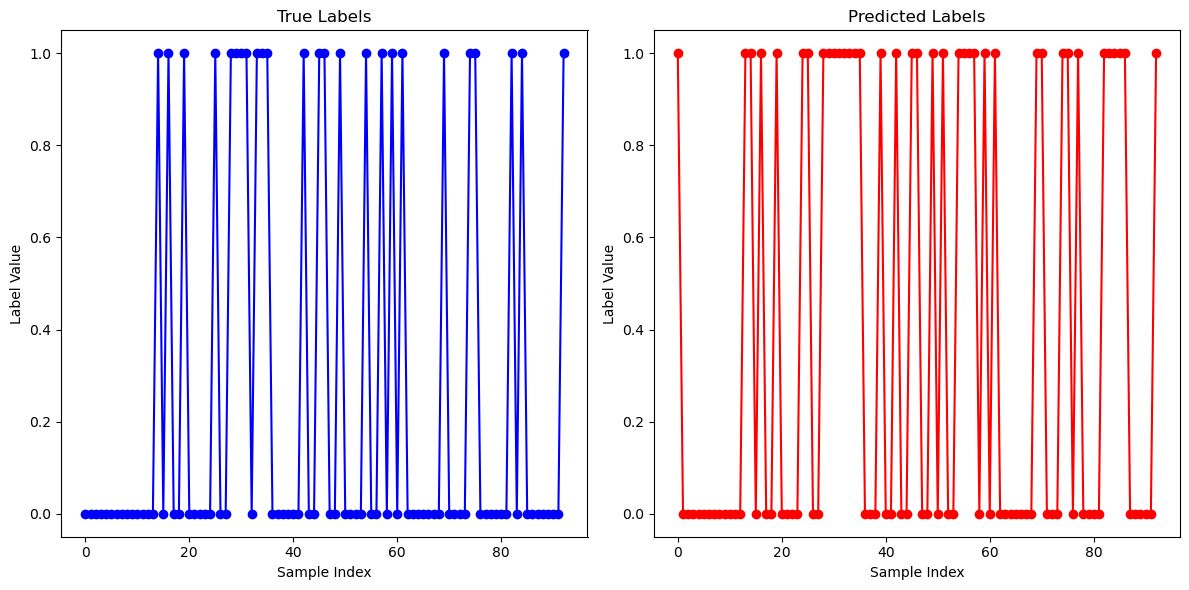

In [11]:
# TODO: Pick the last sequence for each id in the test data

def pick_last_sequences(test_df, sequence_length, feature_columns):
    """Pick the last sequence for each id in the test data."""
    seq_array_test_last = []
    for engine_id in test_df['unit_number'].unique():
        id_df = test_df[test_df['unit_number'] == engine_id]
        if len(id_df) >= sequence_length:
            last_sequence = id_df[feature_columns].values[-sequence_length:]
            seq_array_test_last.append(last_sequence)
    return np.array(seq_array_test_last)

test_sensor_columns = [f'sensor_measurement_{i}' for i in range(1, 16)]  # Replace with actual sensor columns
test_settings_columns = ['operational_setting_1', 'operational_setting_2', 'operational_setting_3']  # Replace with actual settings columns
test_sequence_columns = test_sensor_columns + test_settings_columns

print(len(test_sequence_columns))

seq_array_test_last = pick_last_sequences(test_df, sequence_length, test_sequence_columns) # Replace with code to select last sequence for each id
print("seq_array_test_last shape:", seq_array_test_last.shape)
#print(seq_array_test_last)

#print(test_df.head())
# TODO: Convert to numpy array and ensure float32 data type
seq_array_test_last = np.array(seq_array_test_last, dtype=np.float32)

# TODO: Pick the labels for the selected sequences
def get_labels(test_df, sequence_length, label_column):
    """Generate labels for the last sequence of each id."""
    labels = []
    for engine_id in test_df['unit_number'].unique():
        id_df = test_df[test_df['unit_number'] == engine_id]
        if len(id_df) >= sequence_length:
            label = id_df.iloc[-1][label_column]
            labels.append(label)
    return np.array(labels, dtype=np.float32)

#y_mask = NotImplemented  # TODO: Replace with code to select labels for sequences with length >= sequence_length
test_label_column = 'label1'
label_array_test_last = get_labels(test_df, sequence_length, test_label_column)  # TODO: Replace with code to select labels for the selected sequences

# Reshape and ensure float32 data type
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)

# TODO: Load the saved model if it exists
model_path = 'best_model.keras'
if os.path.isfile(model_path):
    estimator = load_model(model_path)  # TODO: Replace with code to load the saved model

# TODO: Evaluate the model on the test data
scores_test = estimator.evaluate(seq_array_test_last, label_array_test_last, verbose=0)
print('Accuracy: {}'.format(scores_test[1]))

# TODO: Make predictions and compute confusion matrix
y_pred_test_proba = estimator.predict(seq_array_test_last)
y_pred_test = (y_pred_test_proba > 0.95).astype(int)  # TODO: Replace with code to make predictions and convert to class labels
y_true_test = label_array_test_last.flatten()

# TODO: Create pandas dataframe of y_pred_test and save predictions to CSV file
test_set = pd.DataFrame({'True_Label': y_true_test, 'Predicted_Label': y_pred_test.flatten()})
test_set.to_csv('test_predictions.csv', index=False)

# TODO: Compute confusion matrix
print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true_test, y_pred_test.flatten())  # TODO: Replace with code to compute confusion matrix
print(cm)

# TODO: Compute precision, recall, and F1-score
precision_test = precision_score(y_true_test, y_pred_test.flatten())  # TODO: Replace with code to compute precision
recall_test = recall_score(y_true_test, y_pred_test.flatten())  # TODO: Replace with code to compute recall

from sklearn.metrics import f1_score
f1_test = f1_score(y_true_test, y_pred_test.flatten())  # TODO: Replace with code to compute F1-score
print('Precision: ', precision_test, '\n', 'Recall: ', recall_test, '\n', 'F1-score:', f1_test)

# TODO: Plot predicted and actual data for visual verification

plt.figure(figsize=(12, 6))

# Plot true labels
plt.subplot(1, 2, 1)
plt.plot(y_true_test, 'bo-', label='True Labels')
plt.title('True Labels')
plt.xlabel('Sample Index')
plt.ylabel('Label Value')

# Plot predicted labels
plt.subplot(1, 2, 2)
plt.plot(y_pred_test.flatten(), 'ro-', label='Predicted Labels')
plt.title('Predicted Labels')
plt.xlabel('Sample Index')
plt.ylabel('Label Value')

plt.tight_layout()
plt.show()

In [12]:
results_df = pd.DataFrame([[scores_test[1],precision_test,recall_test,f1_test],
                          [0.94, 0.952381, 0.8, 0.869565]],
                         columns = ['Accuracy', 'Precision', 'Recall', 'F1-score'],
                         index = ['LSTM',
                                 'Template Best Model'])
results_df

,Accuracy,Precision,Recall,F1-score
LSTM,0.827957,0.657895,1.0,0.793651
Template Best Model,0.940000,0.952381,0.8,0.869565


## GRU

In [13]:
from keras.layers import GRU

# Define the number of features and output units
nb_features = X_sequences.shape[2]

if label1_array.ndim == 1:
    label1_array = label1_array.reshape(-1, 1)
nb_out = label1_array.shape[1]

# Create a Sequential model
model = Sequential()

#Replace LSTM with GRU
model.add(GRU(units=16, input_shape=(sequence_length, nb_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(units=8, return_sequences=False))
model.add(Dropout(0.2))

# Add a Dense output layer with sigmoid activation
model.add(Dense(units=nb_out, activation='sigmoid'))

# Compile the model with binary crossentropy loss and Adam optimizer
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# TODO: Print the model summary
model.summary()

c:\Users\jardi\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 50, 16)         │         1,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 8)              │           624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,361 (9.22 KB)

 Trainable params: 2,361 (9.22 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# TODO: Fit the network to the training data
history = model.fit(
    X_sequences,
    label1_array,
    epochs=30,  # TODO: Replace with the desired number of training epochs
    batch_size=32,  # TODO: Replace with the desired batch size
    validation_split=0.2,  # TODO: Replace with the desired validation split proportion
    verbose=1,  # TODO: Replace with the desired verbosity level
    callbacks = [
        # TODO: Early stopping callback to stop training when validation loss stops improving
        keras.callbacks.EarlyStopping(
            monitor='val_loss',
            min_delta=0.001,  # TODO: Replace with the minimum change in validation loss to qualify as improvement
            patience=5,  # TODO: Replace with the number of epochs to wait before stopping training
            verbose=1,  # TODO: Replace with the desired verbosity level
            mode='min'
        ),
        # TODO: Model checkpoint callback to save the best model based on validation loss
        keras.callbacks.ModelCheckpoint(
            'best_model.keras',  # TODO: Replace with the file path to save the best model
            monitor='val_loss',
            save_best_only=True,
            mode='min',
            verbose=1  # TODO: Replace with the desired verbosity level
        )
    ]
)

Epoch 1/30
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7883 - loss: 0.4419
Epoch 1: val_loss improved from inf to 0.16571, saving model to best_model.keras
394/394 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - accuracy: 0.7885 - loss: 0.4416 - val_accuracy: 0.9276 - val_loss: 0.1657
Epoch 2/30
392/394 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9411 - loss: 0.1567
Epoch 2: val_loss improved from 0.16571 to 0.14577, saving model to best_model.keras
394/394 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.9412 - loss: 0.1567 - val_accuracy: 0.9390 - val_loss: 0.1458
Epoch 3/30
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9606 - loss: 0.1081
Epoch 3: val_loss improved from 0.14577 to 0.07451, saving model to best_model.keras
394/394 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.9606 - loss: 0.1081 - val_accuracy: 0.9711 - val_loss: 0.0745
Epoch 4/30
392/394 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9650 - loss: 0.0807
Epoch 4: val_loss improved from 0.07451 to 0.0

## Model Eval on Test Set

Training Accuracy: 0.9779879450798035
Validation Accuracy: 0.9634572863578796


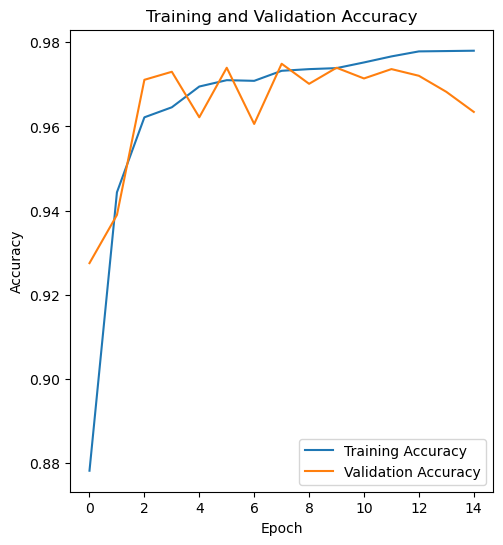

Training Loss: 0.05299017205834389
Validation Loss: 0.08811257779598236


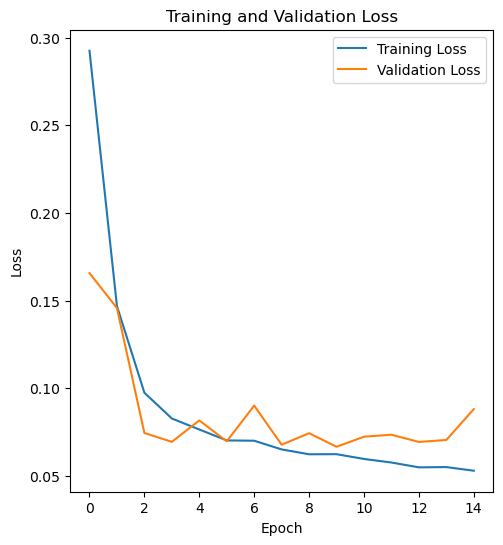

Training Loss: 0.06501913070678711
Training Accuracy: 0.9719662070274353
492/492 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step
y_true_flat shape: (15731,), unique values: {0, 1}
y_pred_flat shape: (15731,), unique values: {0, 1}
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[12578    53]
 [  374  2726]]
precision =  0.9809283915077366 
 recall =  0.8793548387096775


In [15]:
# TODO: summarize history for Accuracy
print("Training Accuracy:", history.history['accuracy'][-1])
print("Validation Accuracy:", history.history['val_accuracy'][-1])

# TODO: Plot the training & validation accuracy over epochs and display the plot
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# TODO: Save the plot to a file
plt.savefig('accuracy_plot.png')

plt.show()


# TODO: summarize history for Loss
print("Training Loss:", history.history['loss'][-1])
print("Validation Loss:", history.history['val_loss'][-1])

# TODO: Plot the training & validation loss over epochs and display the plot
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# TODO: Save the plot to a file
plt.savefig('loss_plot.png')

plt.show()

# TODO: Use the evaluate method to calculate the accuracy of the model on the training data
scores = model.evaluate(X_sequences, label1_array, verbose=0)  # TODO: Replace with the correct code to evaluate the model on the training data

# Print the accuracy of the model on the training data
print("Training Loss:", scores[0])
print("Training Accuracy:", scores[1])

# make predictions and compute confusion matrix
# TODO: Use the predict method to make predictions on the training data
y_pred_proba = model.predict(X_sequences)

# TODO: Convert the predicted probabilities to class labels (e.g., using a threshold of 0.5)
y_pred = (y_pred_proba > 0.95).astype(int) # TODO: Use predict and convert probabilities to class labels

#y_true = label_array
y_pred_flat = y_pred.flatten()
y_true_flat = label1_array.flatten()


print(f"y_true_flat shape: {y_true_flat.shape}, unique values: {set(y_true_flat)}")
print(f"y_pred_flat shape: {y_pred_flat.shape}, unique values: {set(y_pred_flat)}")

# TODO: Create a Pandas DataFrame from the predicted labels and save it to a CSV file
test_set = pd.DataFrame({'True_Label': y_true_flat, 'Predicted_Label': y_pred_flat})  # TODO: Replace with the correct code to create a DataFrame from the predicted labels
test_set.to_csv('predictions.csv', index=False)

print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
# TODO: Compute the confusion matrix using confusion_matrix from sklearn.metrics
cm = confusion_matrix(y_true_flat, y_pred_flat)  # TODO: Replace with the correct code to compute the confusion matrix
print(cm)

# TODO: Calculate the precision using precision_score and recall using recall_score from sklearn.metrics
precision = precision_score(y_true_flat, y_pred_flat)  # TODO: Replace with the correct code to calculate precision
recall = recall_score(y_true_flat, y_pred_flat)  # TODO: Replace with the correct code to calculate recall
print( 'precision = ', precision, '\n', 'recall = ', recall)

## Model Eval on Validation

18
seq_array_test_last shape: (93, 50, 18)
Accuracy: 0.8709677457809448
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 252ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[59  9]
 [ 0 25]]
Precision:  0.7352941176470589 
 Recall:  1.0 
 F1-score: 0.847457627118644


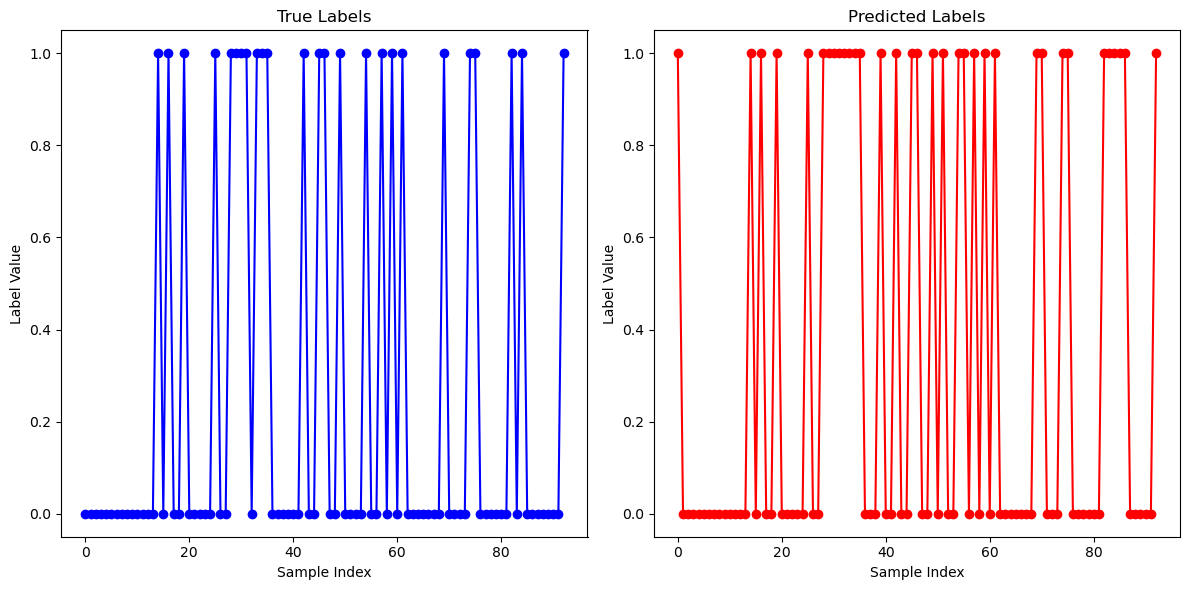

In [16]:
# TODO: Pick the last sequence for each id in the test data

def pick_last_sequences(test_df, sequence_length, feature_columns):
    """Pick the last sequence for each id in the test data."""
    seq_array_test_last = []
    for engine_id in test_df['unit_number'].unique():
        id_df = test_df[test_df['unit_number'] == engine_id]
        if len(id_df) >= sequence_length:
            last_sequence = id_df[feature_columns].values[-sequence_length:]
            seq_array_test_last.append(last_sequence)
    return np.array(seq_array_test_last)

test_sensor_columns = [f'sensor_measurement_{i}' for i in range(1, 16)]  # Replace with actual sensor columns
test_settings_columns = ['operational_setting_1', 'operational_setting_2', 'operational_setting_3']  # Replace with actual settings columns
test_sequence_columns = test_sensor_columns + test_settings_columns

print(len(test_sequence_columns))

seq_array_test_last = pick_last_sequences(test_df, sequence_length, test_sequence_columns) # Replace with code to select last sequence for each id
print("seq_array_test_last shape:", seq_array_test_last.shape)
#print(seq_array_test_last)

#print(test_df.head())
# TODO: Convert to numpy array and ensure float32 data type
seq_array_test_last = np.array(seq_array_test_last, dtype=np.float32)

# TODO: Pick the labels for the selected sequences
def get_labels(test_df, sequence_length, label_column):
    """Generate labels for the last sequence of each id."""
    labels = []
    for engine_id in test_df['unit_number'].unique():
        id_df = test_df[test_df['unit_number'] == engine_id]
        if len(id_df) >= sequence_length:
            label = id_df.iloc[-1][label_column]
            labels.append(label)
    return np.array(labels, dtype=np.float32)

#y_mask = NotImplemented  # TODO: Replace with code to select labels for sequences with length >= sequence_length
test_label_column = 'label1'
label_array_test_last = get_labels(test_df, sequence_length, test_label_column)  # TODO: Replace with code to select labels for the selected sequences

# Reshape and ensure float32 data type
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)

# TODO: Load the saved model if it exists
model_path = 'best_model.keras'
if os.path.isfile(model_path):
    estimator = load_model(model_path)  # TODO: Replace with code to load the saved model

# TODO: Evaluate the model on the test data
scores_test = estimator.evaluate(seq_array_test_last, label_array_test_last, verbose=0)
print('Accuracy: {}'.format(scores_test[1]))

# TODO: Make predictions and compute confusion matrix
y_pred_test_proba = estimator.predict(seq_array_test_last)
y_pred_test = (y_pred_test_proba > 0.95).astype(int)  # TODO: Replace with code to make predictions and convert to class labels
y_true_test = label_array_test_last.flatten()

# TODO: Create pandas dataframe of y_pred_test and save predictions to CSV file
test_set = pd.DataFrame({'True_Label': y_true_test, 'Predicted_Label': y_pred_test.flatten()})
test_set.to_csv('test_predictions.csv', index=False)

# TODO: Compute confusion matrix
print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true_test, y_pred_test.flatten())  # TODO: Replace with code to compute confusion matrix
print(cm)

# TODO: Compute precision, recall, and F1-score
precision_test = precision_score(y_true_test, y_pred_test.flatten())  # TODO: Replace with code to compute precision
recall_test = recall_score(y_true_test, y_pred_test.flatten())  # TODO: Replace with code to compute recall

from sklearn.metrics import f1_score
f1_test = f1_score(y_true_test, y_pred_test.flatten())  # TODO: Replace with code to compute F1-score
print('Precision: ', precision_test, '\n', 'Recall: ', recall_test, '\n', 'F1-score:', f1_test)

# TODO: Plot predicted and actual data for visual verification

plt.figure(figsize=(12, 6))

# Plot true labels
plt.subplot(1, 2, 1)
plt.plot(y_true_test, 'bo-', label='True Labels')
plt.title('True Labels')
plt.xlabel('Sample Index')
plt.ylabel('Label Value')

# Plot predicted labels
plt.subplot(1, 2, 2)
plt.plot(y_pred_test.flatten(), 'ro-', label='Predicted Labels')
plt.title('Predicted Labels')
plt.xlabel('Sample Index')
plt.ylabel('Label Value')

plt.tight_layout()
plt.show()

In [17]:
results_df = pd.DataFrame([[scores_test[1],precision_test,recall_test,f1_test],
                          [0.94, 0.952381, 0.8, 0.869565]],
                         columns = ['Accuracy', 'Precision', 'Recall', 'F1-score'],
                         index = ['GRU',
                                 'Template Best Model'])
results_df

,Accuracy,Precision,Recall,F1-score
GRU,0.870968,0.735294,1.0,0.847458
Template Best Model,0.940000,0.952381,0.8,0.869565


## Comparisons

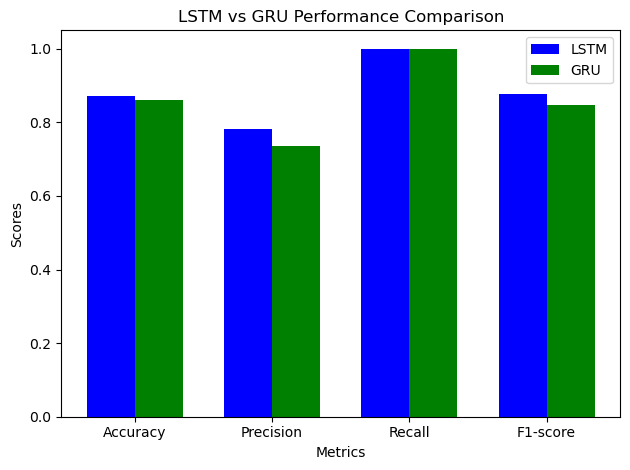

In [18]:
# Data
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
lstm_scores = [0.870968,	0.781250,	1.0,	0.877193] 
gru_scores = [0.860215,	0.735294,	1.0,	0.847458] 

# Plot bar graph
bar_width = 0.35
index = np.arange(len(metrics))

fig, ax = plt.subplots()
bar1 = ax.bar(index, lstm_scores, bar_width, label='LSTM', color='b')
bar2 = ax.bar(index + bar_width, gru_scores, bar_width, label='GRU', color='g')

# Add labels
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('LSTM vs GRU Performance Comparison')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(metrics)
ax.legend()

plt.tight_layout()
plt.show()